# Defining Boundary Conditions using `proteus.SpatialTools`

## Using proteus.mprans.BoundaryConditions for two-phase flows

In [1]:
%matplotlib notebook
# general imports
from proteus import Domain
from proteus.mprans import SpatialTools as st
import numpy as np
from nbtools import plot_domain # only for this notebook

Firstly, the domain geometry is defined.

<IPython.core.display.Javascript object>


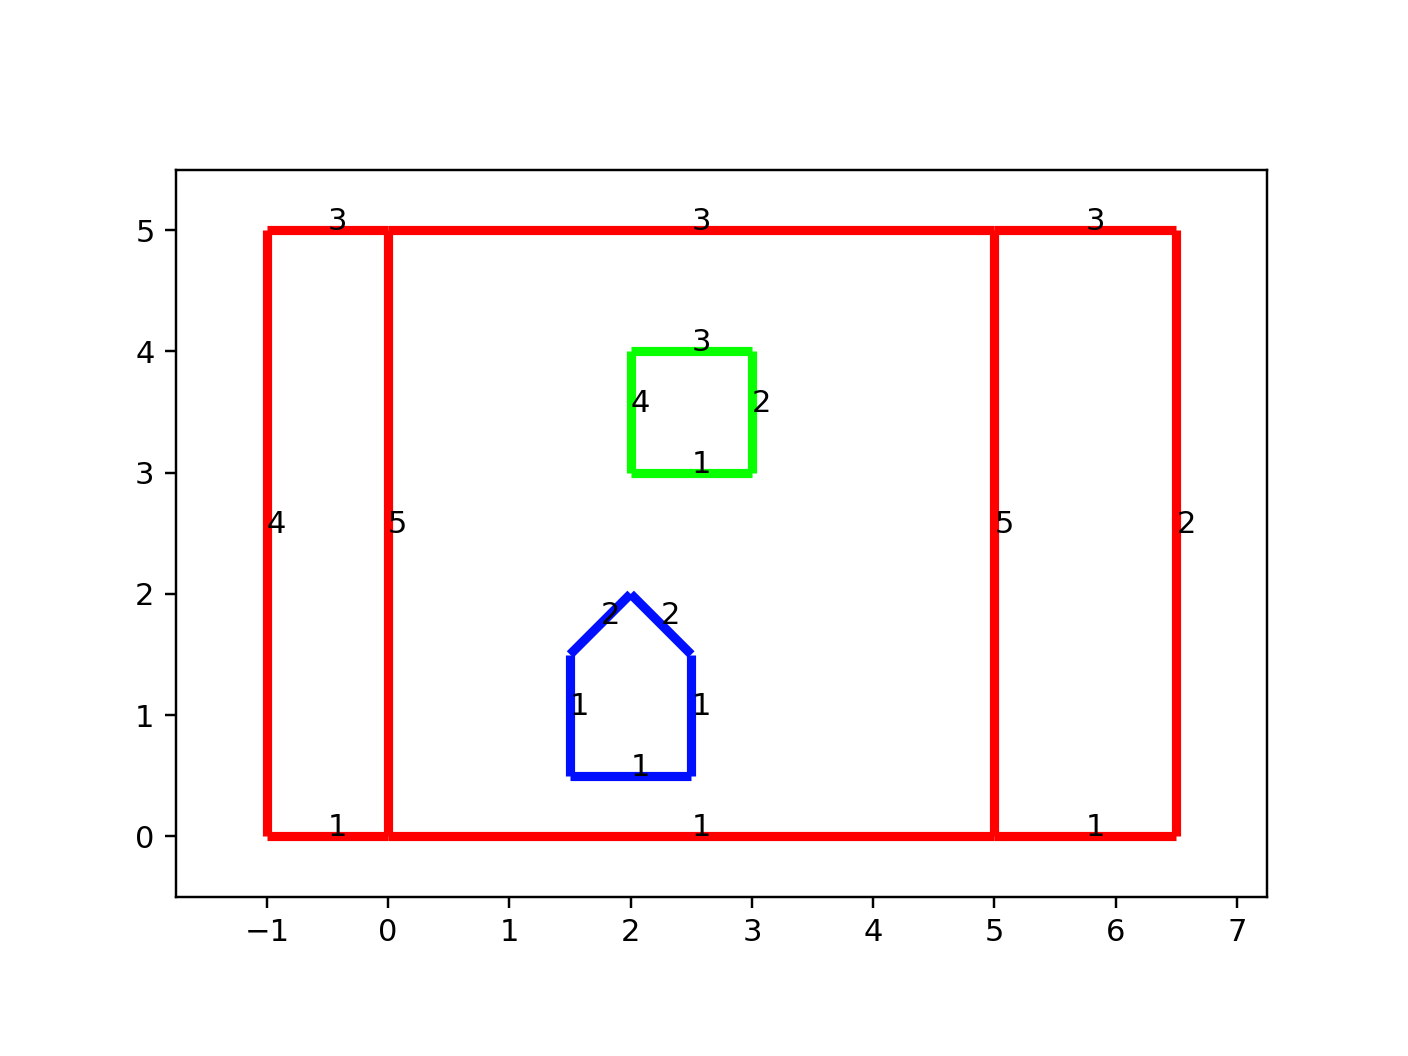

In [2]:
# domain
domain = Domain.PlanarStraightLineGraphDomain()

# various geometries
my_tank = st.Tank2D(domain, dim=[5., 5.])
my_tank.setSponge(x_n=1., x_p=1.5)
my_rect = st.Rectangle(domain, dim=[1., 1.], coords=[2.5, 3.5])
my_custom = st.CustomShape(domain, boundaryTags={'tag1': 1, 'tag2': 2},
                           vertices=[[0., 0.], [1., 0.], [1., 1.], [0.5, 1.5], [0., 1.]], vertexFlags=[1, 1, 2, 2, 2],
                           segments=[[0, 1], [1, 2], [2, 3], [3, 4], [4, 0]], segmentFlags=[1, 1, 2, 2, 1],
                           regions=[[0.5, 0.5]], regionFlags=[1])
my_custom.translate([1.5, 0.5])
plot_domain(domain, flags='local')

When the shape is created, boundary condition class instances (from proteus.mprans.BoundaryConditions) are stored in a dictionary. There are as many boundary conditions in the dictionary as there are boundary tags.

In [3]:
print('Boundary condition tags in shapes defined above:')
print('tank BC:', my_tank.BC.keys())
print('rectangle BC:', my_rect.BC.keys())
print('custom BC', my_custom.BC.keys())

Boundary condition tags in shapes defined above:
tank BC: dict_keys(['y-', 'x+', 'y+', 'x-', 'sponge'])
rectangle BC: dict_keys(['y-', 'x+', 'y+', 'x-'])
custom BC dict_keys(['tag1', 'tag2'])


When the domain is assembled, the flags are updated and used to access boundary conditions directly.

local index: 1
global index: 10


<IPython.core.display.Javascript object>


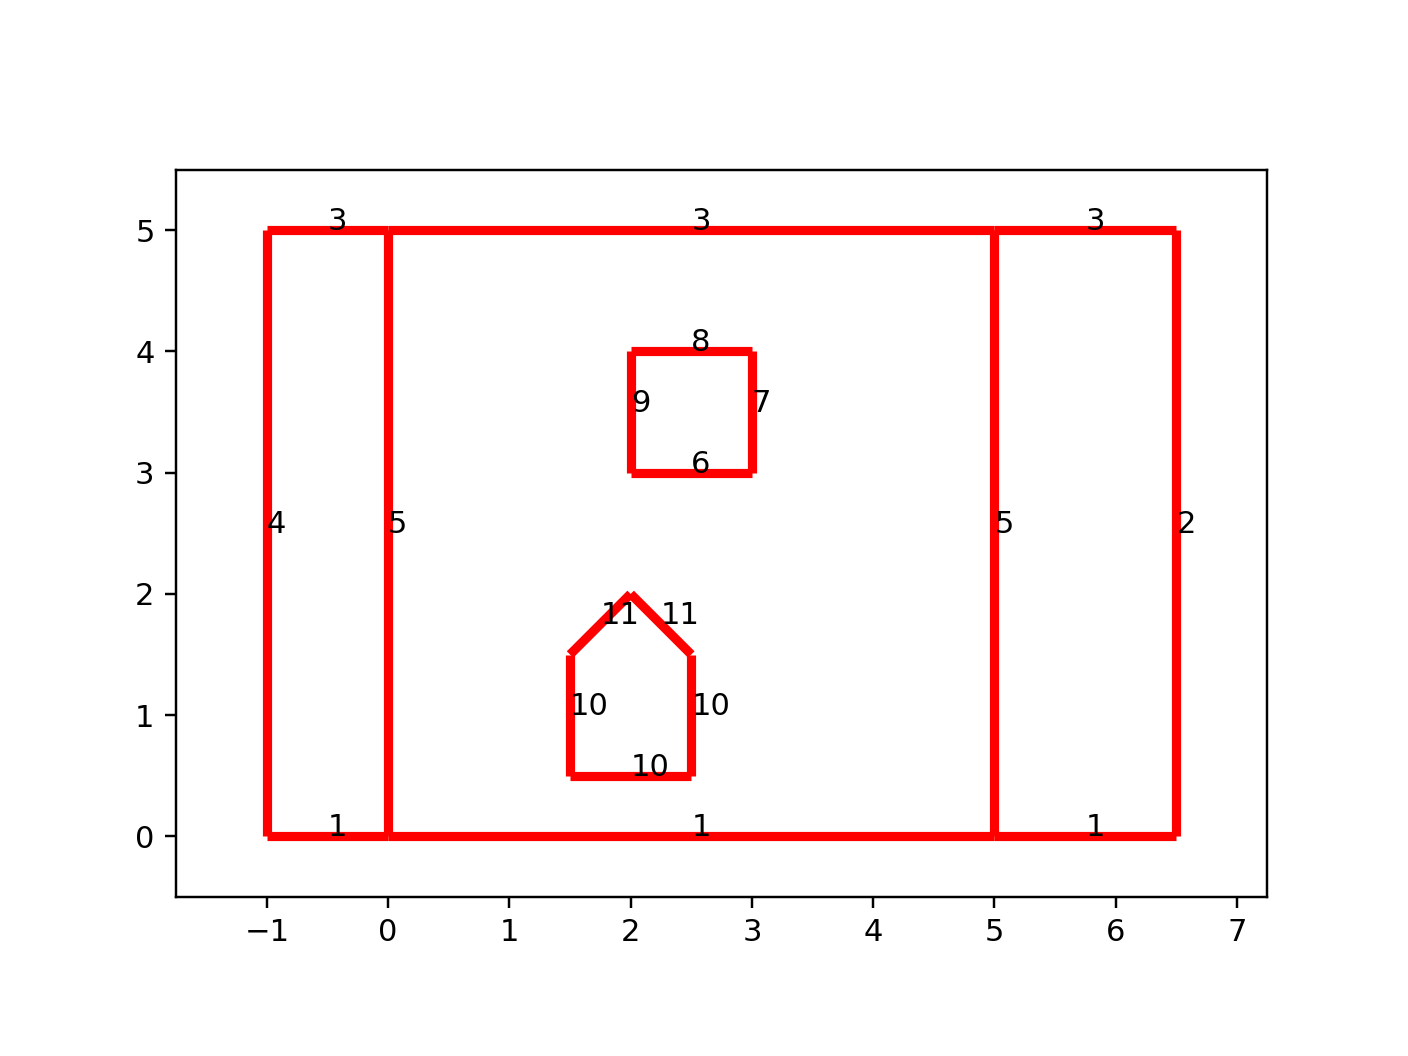

In [4]:
ind_local = my_custom.BC_list.index(my_custom.BC['tag1'])+1 # get index of BC in shape (starts at 1)
ind_global = domain.bc.index(my_custom.BC['tag1'])
print('local index:', ind_local)
print('global index:', ind_global)

plot_domain(domain, flags='global')

## Boundary conditions on segments (2D) or facets (3D)

Boundary conditions are always functions of space (`x`) and time (`t`) so an individual boundary condition component must be set as a python function taking the arguments `(x, t)` (with `x` an array of length 3, and `t` a scalar value).

Individual components of the boundary conditions be accessed through the dictionary (`shape.BC_dict['tag']`) of a shape by providing the intended tag. It is also possible to iterate through the list of boundary conditions (`shape.BC_list`) to rapidly set boundary conditions on all boundary of the shape at once. If the tag has a valid python variable name, it can also be accessed as `shape.BC.tag`.

In [5]:
rightBC = my_rect.BC['x+']  # access boundary condition class
import BoundaryConditions
BoundaryConditions.BoundaryCondition?
rightBC.u_dirichlet.uOfXT = lambda x, t: 0
rightBC.v_dirichlet.uOfXT = lambda x, t: 0
rightBC.w_dirichlet.uOfXT = lambda x, t: 0

rightBC.p_advective.uOfXT = lambda x, t: 0
rightBC.vof_advective.uOfXT = lambda x, t: 0
rightBC.k_dirichlet.uOfXT = lambda x, t: 0
rightBC.dissipation_diffusive.uOfXT = lambda x, t: 0

# showing all the individual boundary condition variables
rightBC?
for key in rightBC:
    valid_keys=['dirichlet', 'advective', 'diffusive', 'stress']
    for valid_key in valid_keys:
        if valid_key in key:
            print(key)

Init signature: BoundaryConditions.BoundaryCondition(self, /, *args, **kwargs)
Docstring:     
Boundary condition class

Attributes
----------
uOfXT: func or None
    boundary condition function of x (array_like) and t (float) or None for
    no boundary condition
File:           ~/proteus/proteus/BoundaryConditions.cpython-37-x86_64-linux-gnu.so
Type:           type
Subclasses:     


Type:        BC_RANS
String form: <mprans.BoundaryConditions.BC_RANS object at 0x55e71af60cf8>
File:        ~/proteus/proteus/mprans/BoundaryConditions.cpython-37-x86_64-linux-gnu.so
Docstring:   Class regrouping boundary conditions for two-phase flows


TypeError: 'mprans.BoundaryConditions.BC_RANS' object is not iterable

Predefined boundary conditions are a way to easily set all boundary condition components to shape boundaries. These predefined boundary conditions include:
 - `setNoSlip()`: no-slip boundary conditions
 - `setFreeSlip()`: free-slip boundary condition
 - `setOpenAir()`: lets air and water fo out of the tank. When water comes out, it does not come back.
 - `setUnsteadyTwoPhaseVelocityInlet()`: for wave generation. Should be used along with a relaxation zone.
 - `setNonMaterial()`: for boundaries that are not physical, such as a boundary in the tank for a relaxation zone.
 - `setFixedNodes()`: fixes nodes in space and time
 


In [6]:
# through dictionary
my_custom.BC['tag1'].setNoSlip()
my_custom.BC['tag2'].setFreeSlip()

# through list
for BC in my_rect.BC_list:
    BC.setNoSlip()
# through variable name
my_tank.BC['y+'].setAtmosphere()

## Boundary conditions in regions

The regional boundary conditions available in proteus are relaxation zones (absorption/generation zones) and porous zones, where the arguments are:
- **epsFact_solid**: must be half of the region length
- **center**: coordinates of the center of the region
- **orientation**: orientation vector of the absorption zone, going from the external boundary to the boundary of the tank
- **dragAlpha, dragBeta, porosity**: options for porous media. dragAlpha should be 1/viscosity for relaxation zones (default value is 1/1e-6)

### Relaxation Zones

Relaxation zones (wave absorption/generation) impose boundary conditions throughout a region using a blending function
$$
\begin{eqnarray}
\alpha = \frac{e^{d^{3.5}}-1}{e^1-1} \\
\end{eqnarray}
$$
where $d$ scales linearly from 0 (at the tank/relaxation zone boundary) to 1 (at the boundary), $u_n$ is the solution given by the model. This boundary condition is imposed as a source term in the Navier-Stokes equations using the porosity module of Proteus.

#### Absorption Zones

Absorption zones impose a dirichlet velocity of zero using the blending function defined above

In [7]:
my_custom.setAbsorptionZones(flags=1,dragAlpha=10., epsFact_solid=1., center=[1., 2.5], orientation=[1., 0.])

print(my_custom.auxiliaryVariables)

{'RelaxZones': {1: <mprans.BoundaryConditions.RelaxationZone object at 0x55e71b3bb498>}}


The TankD/Tank3D class makes it easier to define, the following has the same effect as above:

In [8]:
my_tank.setAbsorptionZones(dragAlpha=100.0,x_p=True)

print(my_tank.auxiliaryVariables)

{'RelaxZones': {3: <mprans.BoundaryConditions.RelaxationZone object at 0x55e71b3bc288>}}


#### Generation Zones

In [9]:
from proteus import WaveTools as wt
my_waves = wt.MonochromaticWaves(period=0.8, waveHeight=0.03, mwl=0.6, depth=0.6,
                                 g=np.array([0, -9.81, 0.]), waveDir=[1., 0., 0.])
my_tank.setGenerationZones(dragAlpha=100., smoothing=1.0, x_n=True, waves=my_waves, wind_speed=(0., 0.))
my_tank.BC['x-'].setUnsteadyTwoPhaseVelocityInlet(wave=my_waves, smoothing=1.0)

print(my_tank.auxiliaryVariables['RelaxZones'])

{3: <mprans.BoundaryConditions.RelaxationZone object at 0x55e71b3bc288>, 2: <mprans.BoundaryConditions.RelaxationZone object at 0x55e71b3c33c8>}


### Porous Zones


In [10]:
my_custom.setPorousZones(1, porosity=0.5, dragAlpha=1/1e-6, dragBeta=0)

## How are boundary conditions accessed?

### Segment/facet boundary conditions
In the ***_p.py** files, directly through their flags. For example, in twp_navier_stokes_p.py, the dirichlet boundary condition function of u is accessed through, for example: `domain.bc[flag].u_dirichlet`
### Regional boundary conditions
In the ***_n.py** files, auxiliary variables are accessed at each time step when solving navier stokes equations